In [3]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import string

In [7]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    return var1, time
def read_nc_var_notime(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    return var1

def runmean(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)

    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2022-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2022-(startyear+len(years))
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated

def extrapolate_until_2020_drivers(array,var,var_drivers,trend_drivers):
    extented_array=np.empty(13)
    co2_anomaly_1995_2020=[2.46,4.21,6.42,9.1,10.77,13.37,16.77,19.12,21.08,24.01,26.57,28.77,30.89]
    rivn_anomaly_1995_2020=np.arange(1,14)
    print(rivn_anomaly_1995_2020[:])
    if var_drivers[var]=="CO2": 
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(co2_anomaly_1995_2020[:])
    if var_drivers[var]=="RIVN":
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(rivn_anomaly_1995_2020[:])
    print(rivn_anomaly_1995_2020[:])
    array_extrapolated=np.append(array,extended_array)
    return array_extrapolated

def intermediate_point(start_point,end_point,uncertainty,slope_sign):
    point = start_point + (end_point-uncertainty) * slope_sign * start_point/(end_point+uncertainty)
    return point

27
trend chlorophyll= 0.040045094097054104
1992-2002 average chlorophyll increase =  0.08796731698570263
27
trend chlorophyll= 0.0183527133294517
1992-2002 average chlorophyll increase =  0.0900792059747168


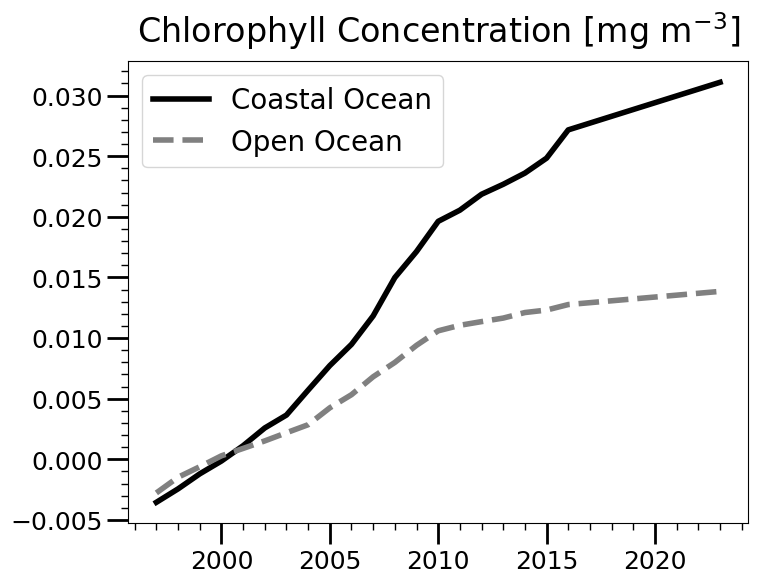

In [8]:
cwd=''
fig, ax =  plt.subplots(1,1,figsize=(8,6))

# plot observations 
# coastal ocean
# chlorophyll starts at 1992, ends at 2019
file_name = "analysis/observations/chl_surf_1993_2019_remap0p5_shelf_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"chl")
var_np = np.squeeze(np.array(var[:]))
print(len(var_np))
var_runmean = extrapolated_runmean(var_np,5)
years = np.arange(1997,1997+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend chlorophyll=",var_runmean_trend*(len(np.arange(1992,2019))))
print("1992-2002 average chlorophyll increase = ",var_runmean_trend*len(np.arange(1992,2019)) / np.mean(var_np[0:10]))
ax.plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:7]))),color="black",linewidth=4)

# plot observations
# open ocean
# chlorophyll starts at 1992, ends at 2019
file_name = "analysis/observations/chl_surf_1993_2019_remap0p5_openocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"chl")
var_np = np.squeeze(np.array(var[:]))
print(len(var_np))
var_runmean = extrapolated_runmean(var_np,5)
years = np.arange(1997,1997+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend chlorophyll=",var_runmean_trend*(len(np.arange(1992,2019))))
print("1992-2002 average chlorophyll increase = ",var_runmean_trend*len(np.arange(1992,2019)) / np.mean(var_np[0:10]))
ax.plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:7]))),color="grey",linewidth=4,linestyle="dashed")###
### Titles & plot settings
ax.set_title("Chlorophyll Concentration [mg m$^{-3}$]",fontsize=24,pad=14)
ax.legend(["Coastal Ocean","Open Ocean"],fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.minorticks_on()
ax.tick_params('both', length=15, width=2, which='major')
ax.tick_params('both', length=5, width=1, which='minor')

    
fig
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
fig.savefig("figures/Global_coastal_chlorophyll.png",dpi=500,bbox_inches='tight',facecolor="white")